# SVD implementation

In [10]:
import surprise
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
from collections import defaultdict

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [11]:
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

In [12]:
def _print(message, verbose):
    if verbose:
        print(message)
        
def load_dataset(data_f):
    df = pd.DataFrame()
    try:
        df[["userID", "itemID", "rating"]] = pd.read_json(data_f)[["userID", "itemID", "rating"]]
    except:
        df = pd.read_json(data_f)
        df.drop_duplicates(subset=["userID", "itemID"], inplace=True)
    return df

def filter_to_sparsity(df, sparsity_percentage, verbose = False):
    # Obtain both usercount and itemcount after filtering
    usercount = df[['userID']].groupby('userID', as_index = False).size()
    itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))

    _print(f"After filtering, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    
    drop_item_ratings = int(-((1-sparsity_percentage) * (usercount.shape[0] * itemcount.shape[0]) - df.shape[0]))
    print(f"To obtain a sparsity of {sparsity_percentage * 100}% we need to drop {drop_item_ratings} ratings")
    drop_indices = np.random.choice(df.index, size=drop_item_ratings)
    df.drop(drop_indices, inplace=True)

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))
    _print(f"After dropping cells, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    return df

def build_data(df):
    reader = Reader(rating_scale=(1,5))
    data = Dataset.load_from_df(df, reader)
    return data

In [13]:
def data_loading_pipeline(fp, sparsity_percentage=None, with_writing=False):
    """
    fp: str = Filepointer to desired user-item-ratings json.
    sparsity_percentage: float = value between 0-1.
    """
    df = load_dataset(fp)
    df = filter_to_sparsity(df, sparsity_percentage)
    data = build_data(df)
    
    return data

### Precision and recall

In [14]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
    
        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [15]:
def DCG(query_relevancy_labels, k):
    # Use log with base 2
    value=min(k,len(query_relevancy_labels))
    sum1=0
    for i in range(value):
      sum1=sum1+((query_relevancy_labels[i])/(np.log2(2+i)))

    return sum1

def NDCG(query_relevancy_labels, k):
    sorted_list= np.sort(query_relevancy_labels)[::-1]
    dcg1 = DCG(query_relevancy_labels, k)
    dcg2 = DCG(sorted_list, k)
    if dcg2 == 0:
      return 0
    else:
      return dcg1/dcg2

In [16]:
def ndcg_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    dcg = dict()
    ndcg = dict()
    for uid, user_ratings in user_est_true.items():
        rel=[]

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        for _, true_r in user_ratings:
          if true_r>=threshold:
            rel.append(true_r)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        #print(rel)

        ndcg[uid] = NDCG(rel, k)

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        #recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return ndcg

### Simulation

In [17]:
results = {}
spt = [0.75, 0.8 , 0.85, 0.9 , 0.95]

In [18]:
for spar in spt:
    data = data_loading_pipeline("../data/AMAZON_FASHION_5.71.268.json",round(spar,2))
    
    raw_ratings = data.raw_ratings
    random.shuffle(raw_ratings)
    #A = 80%, B=20%
    threshold = int(.8 * len(raw_ratings))
    A_raw_ratings = raw_ratings[:threshold]
    B_raw_ratings = raw_ratings[threshold:]
    data.raw_ratings = A_raw_ratings
    
    param_grid = {'n_epochs': [20,30,40,50], 'lr_all': [0.005,0.05],'reg_all': [0.1, 0.4]}
    gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
    gs.fit(data)
    
    svd = gs.best_estimator['rmse']
    trainset = data.build_full_trainset()
    svd.fit(trainset)
    
    predictions = svd.test(trainset.build_testset())
    print('Biased accuracy on A,', end= '  ')
    accuracy.rmse(predictions)
    
    testset = data.construct_testset(B_raw_ratings)
    predictions = svd.test(testset)
    print('Unbiased accuracy on B,', end= ' ')
    accuracy.rmse(predictions)
    
    precisions, recalls = precision_recall_at_k(predictions, k=100, threshold=4)
    ndcg_val = ndcg_at_k(predictions, k=100, threshold=4)
    precisionk=(sum(prec for prec in precisions.values()) / len(precisions))
    recallk=(sum(rec for rec in recalls.values()) / len(recalls))
    ndcgk=(sum(nd for nd in ndcg_val.values()) / len(ndcg_val))
    results[round(spar,2)]= [precisionk , recallk, ndcgk]
print(results)

To obtain a sparsity of 75.0% we need to drop 391 ratings
Biased accuracy on A,  RMSE: 0.0990
Unbiased accuracy on B, RMSE: 0.1489
To obtain a sparsity of 80.0% we need to drop 914 ratings
Biased accuracy on A,  RMSE: 0.0806
Unbiased accuracy on B, RMSE: 0.2052
To obtain a sparsity of 85.0% we need to drop 1438 ratings
Biased accuracy on A,  RMSE: 0.0909
Unbiased accuracy on B, RMSE: 0.1054
To obtain a sparsity of 90.0% we need to drop 1962 ratings
Biased accuracy on A,  RMSE: 0.0850
Unbiased accuracy on B, RMSE: 0.4163
To obtain a sparsity of 95.0% we need to drop 2486 ratings
Biased accuracy on A,  RMSE: 0.0835
Unbiased accuracy on B, RMSE: 0.3028
{0.75: [0.8305647840531561, 0.8289036544850499, 0.8305647840531561], 0.8: [0.8185328185328186, 0.806949806949807, 0.8262548262548263], 0.85: [0.8140495867768595, 0.8140495867768595, 0.8140495867768595], 0.9: [0.7822222222222223, 0.7785185185185186, 0.8088888888888889], 0.95: [0.8084577114427861, 0.8084577114427861, 0.8208955223880597]}


In [19]:
r_pres = []
r_recl = []
r_ndcg = []
for i in results:
    r_pres.append(results[i][0])
    r_recl.append(results[i][1])
    r_ndcg.append(results[i][2])
print(r_pres, r_recl, r_ndcg)

[0.8305647840531561, 0.8185328185328186, 0.8140495867768595, 0.7822222222222223, 0.8084577114427861] [0.8289036544850499, 0.806949806949807, 0.8140495867768595, 0.7785185185185186, 0.8084577114427861] [0.8305647840531561, 0.8262548262548263, 0.8140495867768595, 0.8088888888888889, 0.8208955223880597]


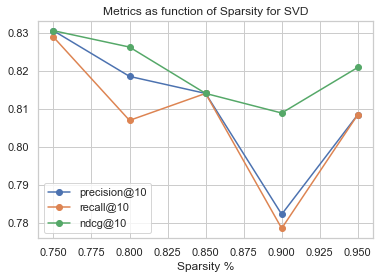

In [22]:
sns.set(style='whitegrid')
plt.plot(spt,r_pres,label="precision@10", marker = "o")
plt.plot(spt,r_recl,label="recall@10", marker = "o")
plt.plot(spt,r_ndcg,label="ndcg@10", marker = "o")

plt.title("Metrics as function of Sparsity for SVD")
plt.xlabel("Sparsity %")
plt.legend()
#plt.savefig(\"../metrics_over_sparsity.png\")

plt.show()